In [1]:
%pip install numpy pandas matplotlib scikit-learn tensorflow keras opencv-python
%pip install scikit-image
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# step 1: Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE


In [3]:
# step 2: Load the dataset, resizing the images to 128x128 pixels

def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                img_path = os.path.join(label_folder, filename)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (128, 128))
                img = img.reshape(128, 128, 3)  # Ensure the image has the shape 128 * 128 with RGB
                images.append(img)
                labels.append(0 if label == 'MaleFaces' else 1)  # Assuming 0 for Male and 1 for Female
    return np.array(images), np.array(labels)

# Use the correct dataset path
folder_path = "./MaleandFemalefacedataset"  # Set this to your dataset path
X, y = load_images_from_folder(folder_path)

# Print the shapes of the loaded dataset
print("X shape:", X.shape)  # x images in total. Each image is resized to be 128x128 pixels, and it has 3 color channels
print("y shape:", y.shape) # label array,  y labels corresponding to the images.


X shape: (5418, 128, 128, 3)
y shape: (5418,)


In [4]:
# step 3: Apply the watershed algorithm to extract features from each image
def apply_watershed(images):
    features = []
    for img in images:
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Apply Gaussian blur to smooth the image
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        # Thresholding the image
        _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        
        # Finding sure background area
        kernel = np.ones((3, 3), np.uint8)
        sure_bg = cv2.dilate(thresh, kernel, iterations=3)
        
        # Finding sure foreground area
        dist_transform = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
        _, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
        
        # Finding unknown region
        unknown = cv2.subtract(sure_bg, np.uint8(sure_fg))
        
        # Label markers for watershed
        _, markers = cv2.connectedComponents(np.uint8(sure_fg))
        markers = markers + 1  # Add one to all labels to distinguish between sure regions
        markers[unknown == 255] = 0  # Mark the unknown region with 0
        
        # Apply watershed algorithm
        img_watershed = img.copy()
        cv2.watershed(img_watershed, markers)
        img_watershed[markers == -1] = [255, 0, 0]  # Mark the boundaries in red
        
        features.append(markers.flatten())  # Use the markers as features (flattened)
        
    return np.array(features)

X_features = apply_watershed(X)


In [5]:
# step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)


In [6]:
# step 5: Optionally apply SMOTE to handle any imbalanced datasets
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


In [7]:
# step 6: Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


In [8]:

# **You can make the model more accurate by modifying these parameters, and MLPClassifier's argument. My computer is just not strong enough for the task**

# step 7: Train the MLP model using grid search to optimize hyperparameters
param_grid = {
    'hidden_layer_sizes': [(64,)], 
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant']
}

mlp = MLPClassifier(max_iter=200, early_stopping=True, n_iter_no_change=3, verbose=True)  # Increase max_iter
grid_search = GridSearchCV(mlp, param_grid, cv=3)
grid_search.fit(X_train_scaled, y_train_res)



Iteration 1, loss = 3.68930615
Validation score: 0.645051
Iteration 2, loss = 1.26574573
Validation score: 0.733788
Iteration 3, loss = 0.48977167
Validation score: 0.822526
Iteration 4, loss = 0.34802681
Validation score: 0.843003
Iteration 5, loss = 0.25160095
Validation score: 0.849829
Iteration 6, loss = 0.15216537
Validation score: 0.901024
Iteration 7, loss = 0.11137227
Validation score: 0.880546
Iteration 8, loss = 0.09164341
Validation score: 0.897611
Iteration 9, loss = 0.06744515
Validation score: 0.883959
Iteration 10, loss = 0.06010240
Validation score: 0.907850
Iteration 11, loss = 0.04945285
Validation score: 0.897611
Iteration 12, loss = 0.04064525
Validation score: 0.928328
Iteration 13, loss = 0.03363111
Validation score: 0.928328
Iteration 14, loss = 0.03217779
Validation score: 0.931741
Iteration 15, loss = 0.03431759
Validation score: 0.924915
Iteration 16, loss = 0.02718377
Validation score: 0.921502
Iteration 17, loss = 0.02155362
Validation score: 0.924915
Iterat

GridSearchCV(cv=3,
             estimator=MLPClassifier(early_stopping=True, n_iter_no_change=3,
                                     verbose=True),
             param_grid={'activation': ['relu'], 'alpha': [0.0001],
                         'hidden_layer_sizes': [(64,)],
                         'learning_rate': ['constant'], 'solver': ['adam']})

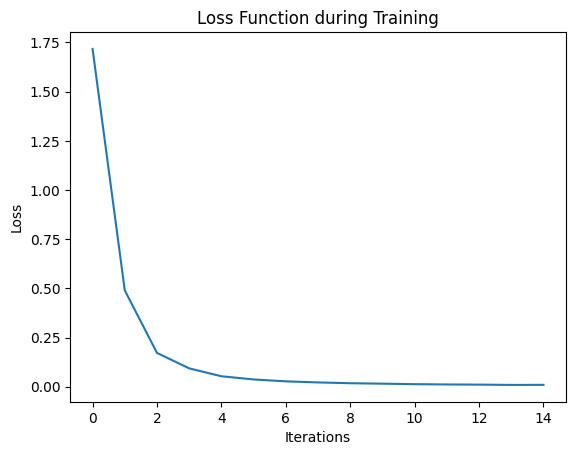

In [9]:
# step 8: Plot the loss function during training
plt.plot(grid_search.best_estimator_.loss_curve_)
plt.title('Loss Function during Training')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()


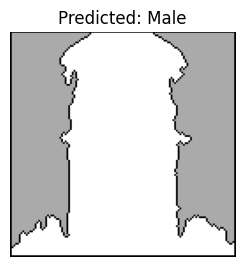

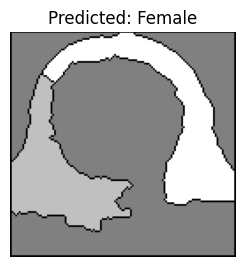

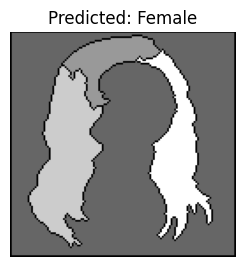

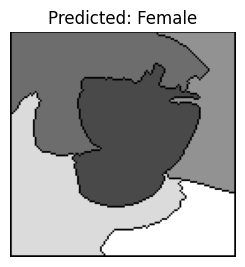

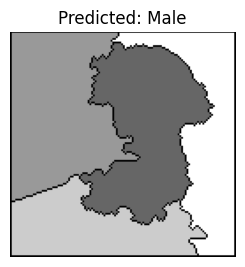

In [16]:
# # step 9: Display the predicted output for some of the test images
predictions = grid_search.predict(X_test_scaled)
for i in range(5):
    plt.subplot(1, 2, 2)
    plt.imshow(X_test[i].reshape(128, 128), cmap='gray')
    plt.title(f'Predicted: {"Female" if predictions[i] == 1 else "Male"}')
    plt.axis('off')
    plt.show()
